In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


import numpy as np

import random
import math
import time
import pandas as pd
import scipy.io


In [2]:
import scipy.io
data1 = scipy.io.loadmat('data/user1-100.mat')
data2 = scipy.io.loadmat('data/user101-150.mat')
data3 = scipy.io.loadmat('data/user151-200.mat')
tariff = scipy.io.loadmat('data/Tariff2(1).mat')["Tariff"][0].tolist()
ZP = data1["ZP"].sum(axis=1) + data2["ZP"].sum(axis=1) + data3["ZP"].sum(axis=1)
ZP1 = np.concatenate((data1["ZP"], data2["ZP"][:, 100:], data3["ZP"][:, 150:]), axis=1).T
ZT = np.concatenate((data1["ZTtank"], data2["ZTtank"][:, 100:], data3["ZTtank"][:, 150:]), axis=1).T
pattern = pd.read_csv('data/0519 2000userpattern.csv')
pattern200 = np.array(pattern)[:200, 1:]

In [2]:
df = pd.read_csv('data/0728 200user.csv')

In [60]:
# np.save('data/input_features.npy',df[['ls_move', 'p_norm', 'tariff']])
# np.save('data/p_flex.npy',df[['p_flex']])

In [56]:
# np.save('data/0519 2000userpattern.npy',pattern)
# np.save('data/ZP1.npy',ZP1)
# np.save('data/ZP.npy',ZP)
# np.save('data/ZT.npy',ZT)

In [3]:
data_input = np.load('data/input_features.npy')
data_output = np.load('data/p_flex.npy')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_input = scaler.fit_transform(data_input)
scaled_output = scaler.fit_transform(data_output)

time_stamp = 96
scaled_train_in = scaled_input[:243*96-96*31]
scaled_train_out = scaled_output[:243*96-96*31]
scaled_test_in = scaled_input[243*96-96*31:]
scaled_test_out = scaled_output[243*96-96*31:]

In [9]:
np.array(scaled_train_in[:100,:])

array([[0.5       , 0.4935    , 0.        ],
       [1.        , 0.45776667, 0.        ],
       [1.        , 0.51941667, 0.        ],
       [1.        , 0.52468333, 0.        ],
       [1.        , 0.5078    , 0.        ],
       [1.        , 0.60728333, 0.        ],
       [1.        , 0.59268333, 0.        ],
       [1.        , 0.61548333, 0.        ],
       [1.        , 0.56736667, 0.        ],
       [1.        , 0.57186667, 0.        ],
       [1.        , 0.14116667, 0.        ],
       [1.        , 0.09141667, 0.        ],
       [1.        , 0.12133333, 0.        ],
       [1.        , 0.2655    , 0.        ],
       [1.        , 0.2355    , 0.        ],
       [1.        , 0.3055    , 0.        ],
       [1.        , 0.23558333, 0.        ],
       [1.        , 0.32058333, 0.        ],
       [1.        , 0.27091667, 0.        ],
       [1.        , 0.59141667, 0.        ],
       [1.        , 0.65058333, 0.        ],
       [1.        , 0.74      , 0.        ],
       [1.

In [71]:
x_test, y_test=[], []
for i in range(30):
    x_test.append(scaled_test_in[i*time_stamp:(i+1)*time_stamp,:3])
    y_test.append(scaled_test_out[(i+1)*time_stamp:(i+2)*time_stamp])
x_test, y_test = np.array(x_test), np.array(y_test)

print(x_test.shape, y_test.shape)



(30, 96, 3) (30, 96, 1)


In [62]:
a = np.load('data/input_features.npy')
a.shape

(23328, 3)

In [4]:
df.head()

,p_norm,p_flex,ls,tariff,ls_move
0,296.10,303.90,1,0.288,0.0
1,274.66,325.34,1,0.288,1.0
2,311.65,288.35,1,0.288,1.0
3,314.81,285.19,1,0.288,1.0
4,304.68,0.00,1,0.288,1.0


In [5]:
#生成测试数据
test=df[['p_norm','tariff']]
scaler = MinMaxScaler(feature_range=(0, 1))

x_test=scaler.fit_transform(test[96*243-96*2:96*243-96*1])
real_test=df[['p_norm']][96*243-96*1:]

In [6]:
#生成up和down不同的96组信号

down = []
for i in range(96):
    row = []
    for j in range(96):
        if j < i:
            row.append(0)
        else:
            row.append(-1)
    down.append(row)
down = np.array(down)

up = []
for i in range(96):
    row = []
    for j in range(96):
        if j < i:
            row.append(0)
        else:
            row.append(1)
    up.append(row)
up = np.array(up)

In [7]:
#修改成只生成最后一天的函数
def flexoneday(p_base, t_base, dr_sig, userpattern):
    p_flex = np.zeros(96 , dtype=int)
    for i in range(200):
        flex = np.zeros(96, dtype=int).tolist()
        temp = t_base[i]
        p = p_base[i]
        pattern = userpattern[i]
        for j in range(96 - 1):
            if dr_sig[j] == 0:
                flex[j] = 0
            elif dr_sig[j] == -1:
                flex[j] = p[j]
                p[j] = 0
                if pattern[j] == 1 or pattern[j] == 2 or pattern[j] == 5:
                    temp[j + 1] = temp[j] - 1.142
                elif pattern[j] == 3:
                    temp[j + 1] = temp[j] - 8.14
                else:
                    temp[j + 1] = temp[j] - 15.143
                if temp[j] <= 60:
                    flex[j] = 0  # 温控信号与dr信号对冲，此后灵活度均降为零
            else:  # 正1信号代表此刻功率变为最大功率
                flex[j] = 3 - p[j]
                p[j] = 3
                if pattern[j] == 1 or pattern[j] == 2 or pattern[j] == 5:
                    temp[j + 1] = temp[j] + 6.4
                elif pattern[j] == 3:
                    temp[j + 1] = temp[j] - 4.6
                else:
                    temp[j + 1] = temp[j] - 8.6
                if temp[j] >= 100:
                    flex[j] = 0  # 温控信号与dr信号对冲，灵活度降为零
        p_flex = p_flex + np.array(flex)
    return p_flex


In [8]:
real_flex_up = []
for i in range(96):
    p=ZP1[:,243*96-96:].copy()# 这一步很关键，否则函数会直接对ZP1进行修改，无法循环
    t=ZT[:,243*96-96:].copy()# 同上
    a=up[i]
    flex = flexoneday(p, t , a, pattern200[:,243*96-96:]).tolist()
    real_flex_up.append(flex)

In [9]:
real_flex_down = []
for i in range(96):
    p=ZP1[:,243*96-96:].copy()
    t=ZT[:,243*96-96:].copy()
    a=down[i]
    flex = flexoneday(p, t , a, pattern200[:,243*96-96:]).tolist()
    real_flex_down.append(flex)

In [10]:
#根据倒数第二天数据进行序列预测
#对信号归一化
scaled_down = np.where(down==0,0.5,0)
scaled_up = np.where(up==0,0.5,1)
test_up =[]
for i in range(96):
    a=np.hstack((np.array(scaled_up[i]).reshape(96,1),x_test))
    test_up.append(a)
test_up = np.array(test_up)
test_down =[]
for i in range(96):
    a=np.hstack((np.array(scaled_down[i]).reshape(96,1),x_test))
    test_down.append(a)
test_down = np.array(test_down)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils import weight_norm
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time
import pandas as pd
from Dilated_TCN_Model import TemporalConvNet


In [15]:

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, num_channels, device, output_dim, kernel_sz, dropout):
        super().__init__()

        assert kernel_sz % 2 == 1, "Kernel size must be odd!"

        self.device = device

        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        self.embed = nn.Linear(input_dim, emb_dim)
        self.TCNBlock = TemporalConvNet(emb_dim, num_channels, device, kernel_sz, dropout)
        self.conv2emb = nn.Linear(num_channels[-1], emb_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):# x=[batch, 96 , inputdim]

        embed = self.embed(x)    # embed = [batch size, 96, emd dim]
        conv_input = embed.permute(0, 2, 1)      # conv_input = [batch size, emb dim, 96]
        conv_out = self.TCNBlock(conv_input ).permute(0,2,1)  # conv_out = [batch size, 96 , num_channels(-1)]
        conved = self.conv2emb(conv_out)     # conved = [batch size, 96, emb dim]

        # elementwise sum output (conved) and input (embedded) to be used for attention
        combined = (conved + embed) * self.scale # combined = [batch size, src len, emb dim]

        return conved, combined

# decoder 若也使用dilated_tcn 会造成第i输出考虑过多target,造成cheating
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, n_layers, kernel_sz, dropout, trg_pad_idx, device):
        super().__init__()

        self.kernel_size = kernel_sz
        self.device = device
        self.trg_pad_idx = trg_pad_idx

        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)

        self.Linear1 = nn.Linear(output_dim, emb_dim)

        self.attn_emb2out = nn.Linear(emb_dim, output_dim)
        self.attn_out2emb = nn.Linear(output_dim, emb_dim)

        self.fc_out = nn.Linear(emb_dim, output_dim)

        self.convs = nn.ModuleList([nn.Conv1d(in_channels=emb_dim, out_channels=2 * emb_dim, kernel_size=kernel_sz) for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout)

    def calculate_attention(self, output , conved, encoder_conved, encoder_combined):
        # conved = [batch size, hid dim, trg len]
        # encoder_conved = encoder_combined = [batch size, src len, (hid dim)]
        conved_emb = conved.permute(0, 2, 1)

        conved_emb = self.attn_emb2out(conved_emb)  # conved_emb = [batch size, trg len, output dim]

        combined = (conved_emb + output) * self.scale  # combined = [batch size, trg len, output dim]

        combined = self.attn_out2emb(combined)# combined = [batch size, trg len, hid dim]

        energy = torch.matmul(combined, encoder_conved.permute(0, 2, 1))
        # energy = [batch size, trg len, src len]

        attention = F.softmax(energy, dim=2)

        # attention = [batch size, trg len, src len]

        attended_encoding = torch.matmul(attention, encoder_combined)

        # attended_encoding = [batch size, trg len, hid dim]

        # apply residual connection
        attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale

        # attended_combined = [batch size, hid dim, trg len]

        return attention, attended_combined

    def forward(self, y, encoder_conved, encoder_combined):
        # y = [batch size, 96, output_dim]
        conv_input = self.Linear1(y) # conv_input = [ batch size, 96, emb_dim]
        conv_input = conv_input.permute(0, 2, 1)
        batch_size = conv_input.shape[0]
        hid_dim = conv_input.shape[1]
        for i, conv in enumerate(self.convs):
            # apply dropout
            conv_input = self.dropout(conv_input)

            # need to pad so decoder can't "cheat"
            padding = torch.zeros(batch_size, hid_dim, self.kernel_size - 1).fill_(self.trg_pad_idx).to(self.device)

            padded_conv_input = torch.cat((padding, conv_input), dim=2)

            # padded_conv_input = [batch size, hid dim, trg len + kernel size - 1]

            # pass through convolutional layer
            conved = conv(padded_conv_input) # conved = [batch size, hid dim *2, 96]
            conved = F.glu(conved, dim = 1) # conved = [batch size, hid dim, 96]

            # calculate attention
            attention, conved = self.calculate_attention(y, conved, encoder_conved, encoder_combined)
            # conved [batch size, hid dim, trg len]
            # attention = [batch size, trg len, src len]
            # apply residual connection
            conved = (conved + conv_input) * self.scale
            # conved = [batch size, hid dim, trg len]
            # set conv_input to conved for next loop iteration
            conv_input = conved

        # conved = [batch size, trg len, hid_dim]

        output = self.fc_out(self.dropout(conved.permute(0,2,1)))

        # output = [batch size, trg len, output dim]

        return output, attention


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, y):
        encoder_conved, encoder_combined = self.encoder(x)

        output, attention = self.decoder(y, encoder_conved, encoder_combined)

        return output, attention

channels = [128, 128, 128, 128, 128, 128]
KERNEL_SIZE = 3
dependency = KERNEL_SIZE * len(channels) * (len(channels) + 1) - len(channels)
print('Now your model can capture {} step dependency'.format(dependency))

# 参数预设
INPUT_DIM = 3
EMBED_DIM = 64
OUTPUTDIM = 1
DROPOUT = 0.
TRG_PAD_IDX = 0.
DEC_LAYERS = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

enc = Encoder(INPUT_DIM, EMBED_DIM, channels, device, OUTPUTDIM, KERNEL_SIZE, 0.)
dec = Decoder(OUTPUTDIM, EMBED_DIM, DEC_LAYERS, KERNEL_SIZE, 0., TRG_PAD_IDX, device)

model = Seq2Seq(enc, dec).to(device)




Now your model can capture 120 step dependency


In [16]:

model.load_state_dict(torch.load ('models/0731 TCN attention model 0.pt', map_location='cpu'))
model.eval()


Seq2Seq(
  (encoder): Encoder(
    (embed): Linear(in_features=3, out_features=64, bias=True)
    (TCNBlock): TemporalConvNet(
      (network): Sequential(
        (0): TemporalBlock(
          (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(2,))
          (chomp1): Chomp1d()
          (relu1): ReLU()
          (dropout1): Dropout(p=0.0, inplace=False)
          (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,))
          (chomp2): Chomp1d()
          (relu2): ReLU()
          (dropout2): Dropout(p=0.0, inplace=False)
          (net): Sequential(
            (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(2,))
            (1): Chomp1d()
            (2): ReLU()
            (3): Dropout(p=0.0, inplace=False)
            (4): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,))
            (5): Chomp1d()
            (6): ReLU()
            (7): Dropout(p=0.0, inplace=False)
          )
          (downsample): Conv1d(64, 128, kerne

In [17]:
real_up=pd.DataFrame(real_flex_up).T

In [52]:
real_up[0].values

array([ 25.16,  19.28,  75.76, 102.48, 122.52, 220.4 , 333.48,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ])

In [49]:
pre_flex ,_= model(torch.Tensor(test_up[0].reshape(1,96,3)),torch.Tensor(real_up[0].values.reshape(1,96,1)))

In [50]:
pre_flex.view(1,96).detach().numpy()

array([[ 2.1032701e+01,  1.8830812e+01,  6.7265648e+01,  9.6955276e+01,
         1.0855367e+02,  1.9197731e+02,  2.9206400e+02, -2.2208218e+01,
        -1.2863183e+00, -7.2351837e+00, -9.0670147e+00,  5.8547556e-01,
         6.8779051e-01,  5.4932203e-02,  2.4586777e-01,  6.2678978e-02,
         8.0680661e-03,  1.5356850e-02,  2.3343973e-03, -2.0182505e-04,
         9.6943602e-04,  1.3360940e-03,  1.2890361e-03,  1.2727492e-03,
         1.2734048e-03,  1.2740307e-03,  1.2740605e-03,  1.2740605e-03,
         1.2740605e-03,  1.2740605e-03,  1.2740605e-03,  1.2740605e-03,
         1.2740605e-03,  1.2740605e-03,  1.2740605e-03,  1.2740605e-03,
         1.2740605e-03,  1.2740605e-03,  1.2740605e-03,  1.2740605e-03,
         1.2740605e-03,  1.2740605e-03,  1.2740605e-03,  1.2740605e-03,
         1.2740605e-03,  1.2740605e-03,  1.2740605e-03,  1.2740605e-03,
         1.2740605e-03,  1.2740605e-03,  1.2740605e-03,  1.2740605e-03,
         1.2740605e-03,  1.2740605e-03,  1.2740605e-03,  1.27406

In [35]:
pre_flex_up=[]
for i in range(96):
    pre_flex,_ = model(torch.Tensor(test_up[i].reshape(1,96,3)),torch.Tensor(real_up[i].values.reshape(1,96,1)) )
    scaler.fit_transform(df['p_flex'].values.reshape(-1,1))
    pre_flex = scaler.inverse_transform( pre_flex.view(1,96).detach().numpy())
    pre_flex_up.append(pre_flex)
pre_flex_up = np.array(pre_flex_up)


In [37]:
pre_flex_up[2]

array([[ 9.2216802e-01,  9.3336177e-01,  3.7327164e+04,  5.6521445e+04,
         6.6403789e+04,  1.1604300e+05,  1.7553075e+05,  1.9000608e+05,
        -7.6183701e+03, -4.9609590e+03, -7.3839155e+03, -4.7798853e+03,
        -5.5776996e+02,  1.2968600e+03,  1.9625121e+02,  9.8704048e+01,
         8.4877029e+01,  1.5773255e+01,  6.5292993e+00,  1.1534191e+00,
         9.5732510e-03,  5.8057082e-01,  8.2340014e-01,  7.9586279e-01,
         7.8103912e-01,  7.8174543e-01,  7.8212094e-01,  7.8212094e-01,
         7.8209412e-01,  7.8209412e-01,  7.8209412e-01,  7.8209412e-01,
         7.8209412e-01,  7.8209412e-01,  7.8209412e-01,  7.8209412e-01,
         7.8209412e-01,  7.8209412e-01,  7.8209412e-01,  7.8209412e-01,
         7.8209412e-01,  7.8209412e-01,  7.8209412e-01,  7.8209412e-01,
         7.8209412e-01,  7.8209412e-01,  7.8209412e-01,  7.8209412e-01,
         7.8209412e-01,  7.8209412e-01,  7.8209412e-01,  7.8209412e-01,
         7.8209412e-01,  7.8209412e-01,  7.8209412e-01,  7.82094

In [38]:
real_down=pd.DataFrame(real_flex_down).T
pre_flex_down=[]
for i in range(96):
    pre_flex, _ = model(torch.Tensor(test_down[i].reshape(1,96,3)),torch.Tensor(real_down[i].values.reshape(1,96,1)) )
    scaler.fit_transform(df['p_flex'].values.reshape(-1,1))
    pre_flex = scaler.inverse_transform( pre_flex.view(1,96).detach().numpy())
    pre_flex_down.append(pre_flex)
pre_flex_down = np.array(pre_flex_down)


In [39]:
#生成灵活度表征函数
#上备用
real_up_1step=[]
for i in range(96):
    a=real_flex_up[i][i]
    real_up_1step.append(a)
real_up_1step=np.array(real_up_1step)

real_up_2step=[]
for i in range(48):
    a=[real_flex_up[i][i],real_flex_up[i][i+1]]
    b=np.min(a)
    real_up_2step.append(b)
    real_up_2step.append(b)
real_up_2step=np.array(real_up_2step)

real_up_4step=[]
for i in range(24):
    a=[real_flex_up[i][i],real_flex_up[i][i+1],real_flex_up[i][i+2],real_flex_up[i][i+3]]
    b=np.min(a)
    real_up_4step.append(b)
    real_up_4step.append(b)
    real_up_4step.append(b)
    real_up_4step.append(b)
real_up_4step=np.array(real_up_4step)
 



In [40]:
pre_flex_up=pre_flex_up.reshape(96,96)
pre_flex_down=pre_flex_down.reshape(96,96)

In [41]:
pre_up_1step=[]
for i in range(96):
    a=pre_flex_up[i][i]
    pre_up_1step.append(a)
pre_up_1step=np.array(pre_up_1step)

pre_up_2step=[]
for i in range(48):
    a=[pre_flex_up[i][i],pre_flex_up[i][i+1]]
    b=np.min(a)
    pre_up_2step.append(b)
    pre_up_2step.append(b)
pre_up_2step=np.array(pre_up_2step)

pre_up_4step=[]
for i in range(24):
    a=[pre_flex_up[i][i],pre_flex_up[i][i+1],pre_flex_up[i][i+2],pre_flex_up[i][i+3]]
    b=np.min(a)
    pre_up_4step.append(b)
    pre_up_4step.append(b)
    pre_up_4step.append(b)
    pre_up_4step.append(b)
pre_up_4step=np.array(pre_up_4step)
 



In [42]:
#下备用
real_down_1step=[]
for i in range(96):
    a=real_flex_down[i][i]
    real_down_1step.append(a)
real_down_1step=np.array(real_down_1step)

real_down_2step=[]
for i in range(48):
    a=[real_flex_down[i][i],real_flex_down[i][i+1]]
    b=np.min(a)
    real_down_2step.append(b)
    real_down_2step.append(b)
real_down_2step=np.array(real_down_2step)

real_down_4step=[]
for i in range(24):
    a=[real_flex_down[i][i],real_flex_down[i][i+1],real_flex_down[i][i+2],real_flex_down[i][i+3]]
    b=np.min(a)
    real_down_4step.append(b)
    real_down_4step.append(b)
    real_down_4step.append(b)
    real_down_4step.append(b)
real_down_4step=np.array(real_down_4step)
 




In [43]:
pre_down_1step=[]
for i in range(96):
    a=pre_flex_down[i][i]
    pre_down_1step.append(a)
pre_down_1step=np.array(pre_down_1step)

pre_down_2step=[]
for i in range(48):
    a=[pre_flex_down[i][i],pre_flex_down[i][i+1]]
    b=np.min(a)
    pre_down_2step.append(b)
    pre_down_2step.append(b)
pre_down_2step=np.array(pre_down_2step)

pre_down_4step=[]
for i in range(24):
    a=[pre_flex_down[i][i],pre_flex_down[i][i+1],pre_flex_down[i][i+2],pre_flex_down[i][i+3]]
    b=np.min(a)
    pre_down_4step.append(b)
    pre_down_4step.append(b)
    pre_down_4step.append(b)
    pre_down_4step.append(b)
pre_down_4step=np.array(pre_down_4step)
 



In [44]:
pre_up_1step.shape

(96,)

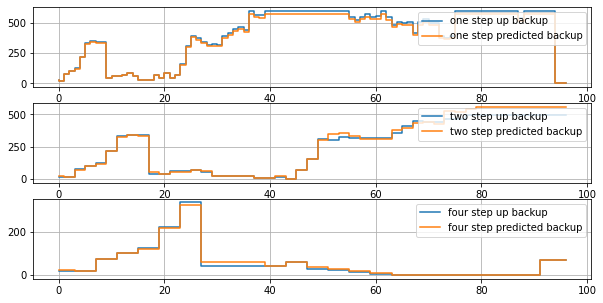

In [46]:
#画图
plt.figure(figsize=(10,5))
ax1 = plt.subplot(311)
x1=np.linspace(0,96,96).astype(int)
l1=plt.step(x1,real_up_1step,label='one step up backup')
l2=plt.step(x1,pre_up_1step/500,label='one step predicted backup')
plt.legend(loc = 'upper right')
# plt.yticks(y)
plt.grid()

ax2 = plt.subplot(312)
l1=plt.step(x1,real_up_2step,label='two step up backup')
l2=plt.step(x1,pre_up_2step/500,label='two step predicted backup')
plt.legend(loc = 'upper right')
# plt.yticks(y)
plt.grid()

ax3 = plt.subplot(313)
l1=plt.step(x1,real_up_4step,label='four step up backup')
l2=plt.step(x1,pre_up_4step/500,label='four step predicted backup')
plt.legend(loc = 'upper right')
# plt.yticks(y)
plt.grid()



plt.show()



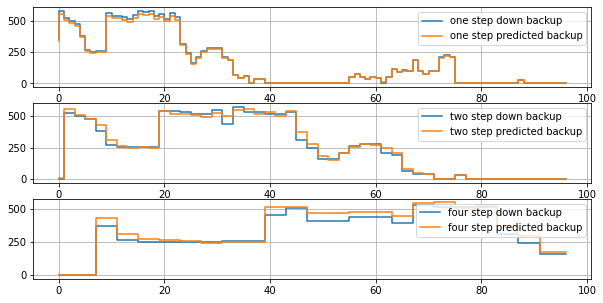

In [51]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(311)
x1=np.linspace(0,96,96).astype(int)
l1=plt.step(x1,real_down_1step,label='one step down backup')
l2=plt.step(x1,pre_down_1step/500,label='one step predicted backup')
plt.legend(loc = 'upper right')
# plt.yticks(y)
plt.grid()

ax2 = plt.subplot(312)
l1=plt.step(x1,real_down_2step,label='two step down backup')
l2=plt.step(x1,pre_down_2step/500,label='two step predicted backup')
plt.legend(loc = 'upper right')
# plt.yticks(y)
plt.grid()

ax3 = plt.subplot(313)
l1=plt.step(x1,real_down_4step,label='four step down backup')
l2=plt.step(x1,pre_down_4step/500,label='four step predicted backup')
plt.legend(loc = 'upper right')
# plt.yticks(y)
plt.grid()



plt.show()



In [54]:
MAX_EPOCH = 2000
train_loss_plot = np.load(r'G:\科研\代码\July_coding\code\train_loss_plot.npy')
val_loss_plot = np.load(r'G:\科研\代码\July_coding\code\val_loss_plot.npy')
train_loss_plot = np.reshape(train_loss_plot, [MAX_EPOCH, -1])
val_loss_plot = np.reshape(val_loss_plot, [MAX_EPOCH, -1])

In [ ]:
train

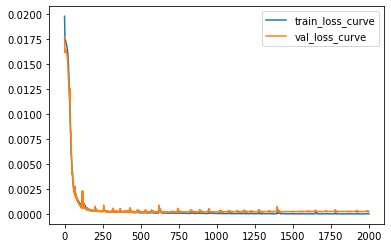

In [56]:
plt.figure()
plt.plot(train_loss_plot)
plt.plot(val_loss_plot)
plt.legend(['train_loss_curve', 'val_loss_curve'])

In [ ]:
np.save('700 ')